<a href="https://colab.research.google.com/github/Bzhamdi/holbertonschool-machine_learning/blob/main/supervised_learning/0x0E-time_series/final_bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing important libraries
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

#Matplotlib configuration
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Import the dataset 
df = pd.read_csv('/content/drive/MyDrive/HOLBERTON/data/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv')

#encode the date
df['Timestamp'] = [datetime.datetime.utcfromtimestamp(x) for x in df['Timestamp']]

# Sorting by the date 
df.sort_values('Timestamp', inplace=True)
#choose useful data points
df = df[df['Timestamp'] >= '2017']
#Remove missing values and Remove unuseful data points
df=df.dropna(axis=0, thresh=7)
#Convert date
date_time = pd.to_datetime(df.pop('Timestamp'), format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)



#Add useful data to dataFrame use sin and cos to convert the time to clear "Time of day" and "Time of year" 
day = 24*60*60
year = (365.2425)*day
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

#save this preprocessed data
#df.to_csv('bitcoin.csv')


In [ ]:
#Split the data
#(70%, 20%, 10%) split for the training, validation, and test sets.
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

#Normalize the data
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

#Data windowing
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}
    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift
    self.total_window_size = input_width + shift
    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]
    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    

In [ ]:
#split_window function
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
#Create tf.data.Datasets functions
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds
#Convert all dataframes to datasates
WindowGenerator.make_dataset = make_dataset
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs,
   labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the
    # `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

In [ ]:
#add datasets to the class
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
#Recurrent neural network
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(24, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
#Comile and fit model functions
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=3):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',shuffle=False)

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam())
  #metrics=[tf.metrics.MeanAbsoluteError()]

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
#plot function
def plot(self, model=None, plot_col='Close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)
    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue
    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
    if n == 0:
      plt.legend()
  plt.xlabel('Time [hours]')


WindowGenerator.plot = plot

In [ ]:
#main work
#create our window
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Close'])

wide_window
#compile and fit model
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()


7336/7336 [==============================] - 33s 5ms/step - loss: 1.1963e-05


In [ ]:
lstm_model.save('coin_predictor.h5')

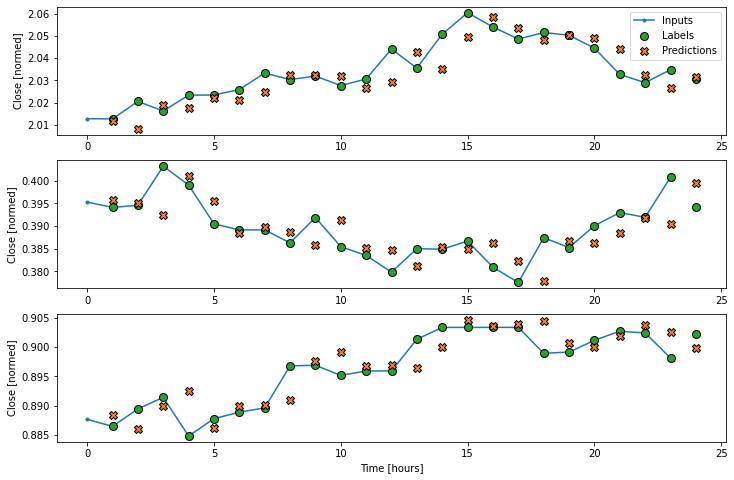

In [ ]:
#plot result
wide_window.plot(lstm_model)